<a href="https://colab.research.google.com/github/debyyamamoto/atividades_rec_musical/blob/main/C%C3%B3pia_de_lab05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-9yedyrpc
  Running command git clone --filter=blob:none --quiet https://github.com/flaviovdf/musica.git /tmp/pip-req-build-9yedyrpc
  Resolved https://github.com/flaviovdf/musica.git to commit 19c84b84ab1cd1a6a6e0fdefbf33fc9c796c1949
  Preparing metadata (setup.py) ... done
  Created wheel for musica_dcc_ufmg: filename=musica_dcc_ufmg-0.1-py3-none-any.whl size=3384 sha256=44cca9ce5c1db7883422ea67d4d003d1afdf25ae088283f8db863357091bbb6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-9faxeooi/wheels/75/fd/b5/f4508a3d593651a0964d76a8aeb9faf32c1da6dc23cbe5da2a
Successfully built musica_dcc_ufmg


# Dynamic Time Warping

**Objetivos**
1. Implementar o algoritmo de DTW
1. Entender a diferença entre performances da mesma música

**Resultado Esperado**
1. Entendimento do Cromagrama
1. Entedimento da tarefa de alinhamento de músicas

In [ ]:
from musica import mu_files
from musica import mu_plots

from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [ ]:
mu_files.download('https://dcc.ufmg.br/~flaviovdf/mir/lab05/files.zip', 'files.zip',
             False)
mu_files.extract('files.zip', '.')

files.zip: 45.7MB [00:09, 5.30MB/s]


In [ ]:
mu_plots.init_matplotlib()
plt.ion()

## Introdução

Como vimos em sala de aula, a tarefa de alinhamento de músicas tem diversas aplicações possíveis. Neste notebook, vamos explorar o conceito de *Dynamic Time Warping* para comparar diferentes versões de uma mesma música.

Em tarefas de Recuperação de Informação Musical, é comum comparar duas sequências de comprimentos diferentes. Por exemplo, um objetivo simples pode ser em calcular uma medida de similaridade entre duas versões da mesma música. Em outras palavras, entre dois sinais $x$ e $y$.

Tais sinais podem ter sequências semelhantes de progressões de acordes e instrumentações. Porém, podem haver desvios de batidas por minuto entre os dois. Para entender melhor, compare as duas versões da mesma música abaixo.

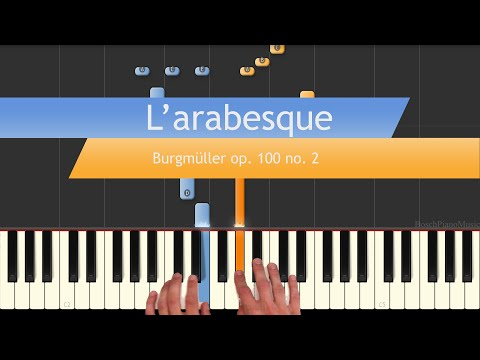

In [ ]:
ipd.YouTubeVideo('ZTJ0AYKNdgI')

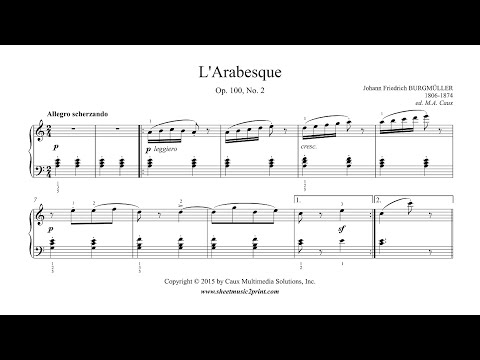

In [ ]:
ipd.YouTubeVideo('1oMm_n38OxQ')

Observe como cada versão diferente tem uma duração distinta. Mesmo que expressássemos os dois sinais de áudio usando o mesmo espaço de recursos (por exemplo, espectrogramas), não poderíamos simplesmente usar uma distâncias entre pares simples. Os sinais têm comprimentos diferentes (4 segundos de diferença).

Como visto em sala de aula, o problema de alinhamento de músicas tem diversas aplicações nas bibliotecas digitais musicais. Uma delas, são aplicativos que permitem o chaveamento entre diferentes versões em um mesmo instante de tempo (na mesma nota). Uma outra é a análise de performance.

Para alinhar músicas vamos fazer uso de *Dynamic Time Warping*.

## Dynamic Time Warping

### Do Wikipedia

Dynamic time warping (DTW) é um algoritmo para comparar e alinhar duas séries temporais. A DTW é utilizada para encontrar o alinhamento não-linear ótimo entre duas sequências de valores numéricos. Dessa maneira, é possível encontrar padrões entre medições de eventos com diferentes ritmos. Por exemplo, é possível casar a série temporal obtida por acelerômetros (ou outros sensores) de duas pessoas andando em diferentes velocidades.

DTW pode ser utilizada para alinhar qualquer tipo de dado que obedeça uma ordem temporal, como vídeo, áudio e imagens. Entre as diversas aplicações da DTW, encontra-se o reconhecimento de fala e de assinatura, bem como o alinhamento de gravações musicais com suas respectivas partituras.

**Exemplo**

Para entender o algoritmo, vamos criar duas vetores de tamanhos distintos.

In [ ]:
x = np.array([1, 4, 4, 2, -4, -4, 9])
y = np.array([1, 3, 4, 3, 1, -1, -2, -1, 12])
nx = len(x)
ny = len(y)

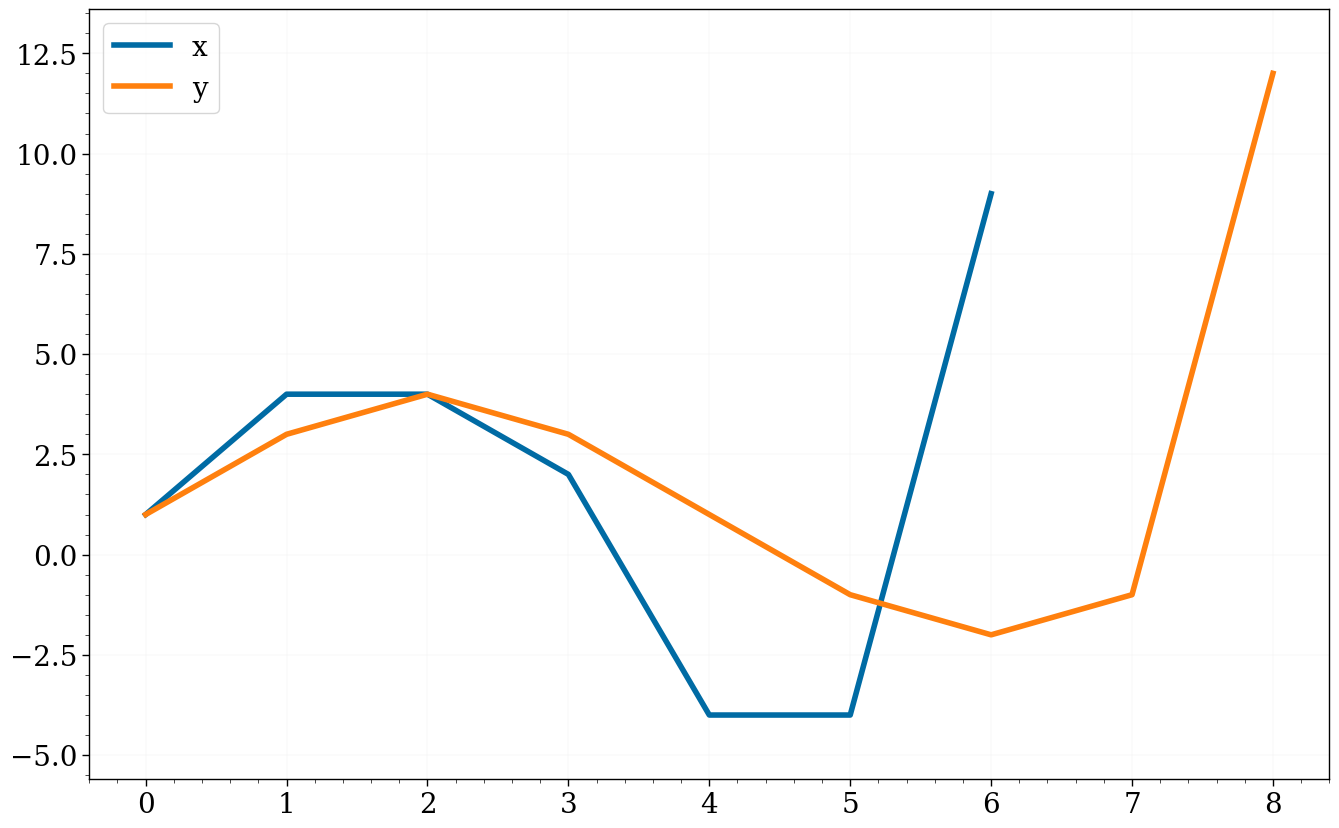

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(x)
ax.plot(y)
ax.legend(('x', 'y'))

Neste exemplo simples, há apenas um valor ou "atributo" em cada índice de tempo. Na prática, você pode usar sequências de vetores, por exemplo, espectrogramas ou cromogramas.

### Distância

O DTW requer o uso de uma métrica de distância entre as observações correspondentes de $x$ e $y$.

**Euclidiana**

Uma escolha comum é a distância euclidiana.

$$d(\mathbf{f}_1, \mathbf{f}_2) = || \mathbf{f}_1 - \mathbf{f}_2 || = \sqrt{\sum_i (\mathbf{f}_1[i] - \mathbf{f}_2[i])^2}$$

Observe como os vetores aqui tem as mesmas dimensões. Tal dimensão **não é o tempo**, sim o **número de observações por tempo**. No exemplo acima temos apenas uma observação por tempo. Porém, ao fazer o cromagrama de uma música, vide abaixo, teremos 12 observações por tempo.

No exemplo abaixo temos duas observações por tempo.

**Coseno**

Uma outra métrica de distância é o 1-coseno. Quando dois vetores apontam na mesma direção, o coseno entre os mesmos é 1. Quando apontam em direções opostas, o coseno vira 0. Assim, vamo fazer 1-coseno vamos capturar uma noção de distância que não se importa com a magnitude dos valores, sim com a direção dos vetores.

![](https://github.com/flaviovdf/musica/blob/main/notebooks/cos.png?raw=1)

In [ ]:
import scipy.spatial as sp
sp.distance.cosine([1, 0], [5, 12])

0.6153846153846154

Observe que magnitudes diferentes apontando na mesma direção

In [ ]:
sp.distance.cosine([1, 1], [9, 9])

0.0

### Cromagrama

Como vimos em sala de aula, podemos usar o **cromagrama**, ou **vetor de cromas**, para representar músicas. Um vetor de croma é um vetor de característica de 12 elementos. Cada elemento indica a quantidade de energia em um *semitom* {C, C #, D, D #, E, ..., B}.

Vamos comparar dois vetores de croma da mesma música usando librosa.

Carregando uma música com librosa. Vamos focar nos primeiros 15 segundos da música apenas. Nossa comparação será de duas versões da música [Body and Soul](https://en.wikipedia.org/wiki/Body_and_Soul_(1930_song)).

**Do Wikipedia**

"Body and Soul" foi escrita para a atriz e cantora inglesa Gertrude Lawrence, sendo interpretada pela primeira vez por ela, ainda na Inglaterra. Libby Holman foi a responsável pelo lançamento da canção nos Estados Unidos. Inicialmente, a música foi proibida de ser executada nas estações de rádio do país, porém a popularidade da canção cresceu muito nas décadas de 1930 e 1940, sendo regravada por uma série de artistas. A primeira regravação de "Body and Soul" foi feita ainda em 1930 pelo cantor estadunidense Louis Armstrong, que após o seu lançamento alcançou o número 12 na parada de singles norte-americana. Até o final da década, a canção havia sido regravada por 11 grupos, senda a mais bem-sucedida nas paradas a versão original da canção lançada por Libby Holman tando atingido o número 3. "Body and Soul" continua a ser um padrão de jazz, com centenas de versões cantadas e gravadas por dezenas de artistas. Clássicas gravações vocais incluem as de: Ella Fitzgerald, Hanshaw Annette, Billie Holiday, Billy Eckstine , Etta James , Sarah Vaughan e Frank Sinatra, e músicos como Benny Goodman, Lee Konitz, John Coltrane, Charles Mingus, Dexter Gordon, Sonny Stitt e Lester Young.

**MP3s**

Na pasta `mp3s` existem diferentes versões de Body and Soul. As mesmas foram identificadas com ajuda da base de dados chamada de [JazzTube](http://mir.audiolabs.uni-erlangen.de/jazztube). O JazzTube contém um série de referências a clássicos do Jazz no YouTube. Caso queira, explore a base pois pode ser uma fonte para projetos futuros.

O professor da disciplina baixou os mp3s do YouTube usando a ferramenta [youtube-dl](https://youtube-dl.org/). Abaixo segue um exemplo de uso da mesma, não precisa executar.

```bash
$ youtube-dl --extract-audio --audio-format mp3 https://www.youtube.com/watch?v=_OFMkCeP6ok
```

*Abaixo uma versão antiga de Chu Berry e Roy Eldridge*

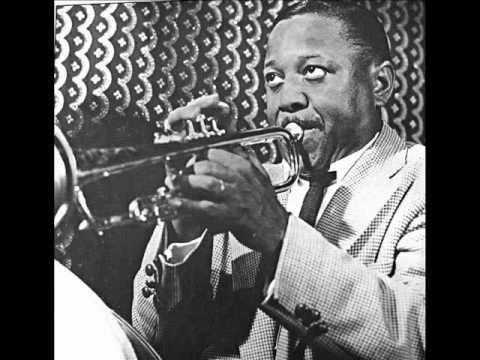

In [ ]:
ipd.YouTubeVideo('Lor80WUVbtw')

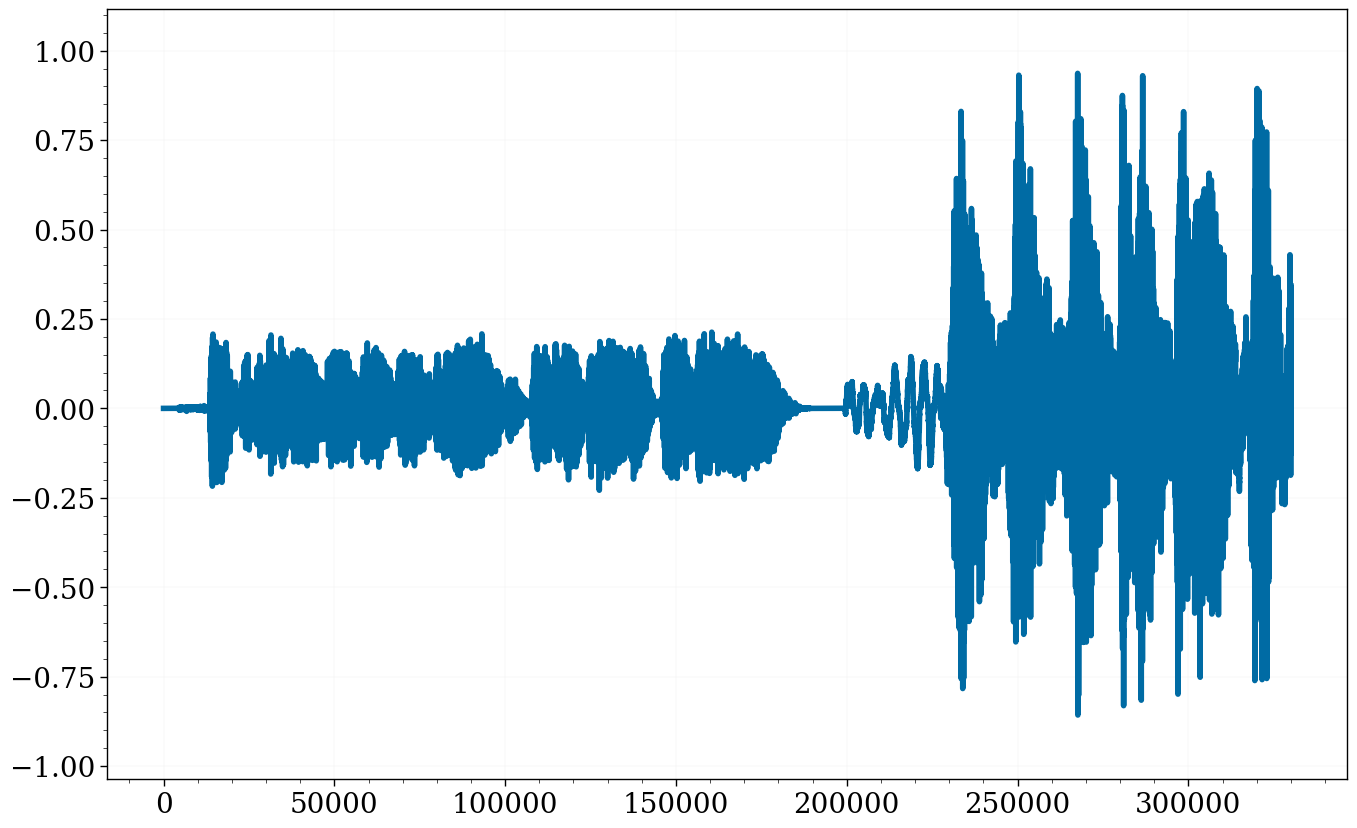

In [ ]:
wave_classic, sr = librosa.load('mp3s/Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.mp3',
                                duration=15, sr=22000)
plt.plot(wave_classic)

Vamos computar o cromograma da música com librosa.

In [ ]:
chroma_classic = librosa.feature.chroma_stft(y = wave_classic, sr=sr)
chroma_classic.shape

(12, 645)

Plotar o mesmo.

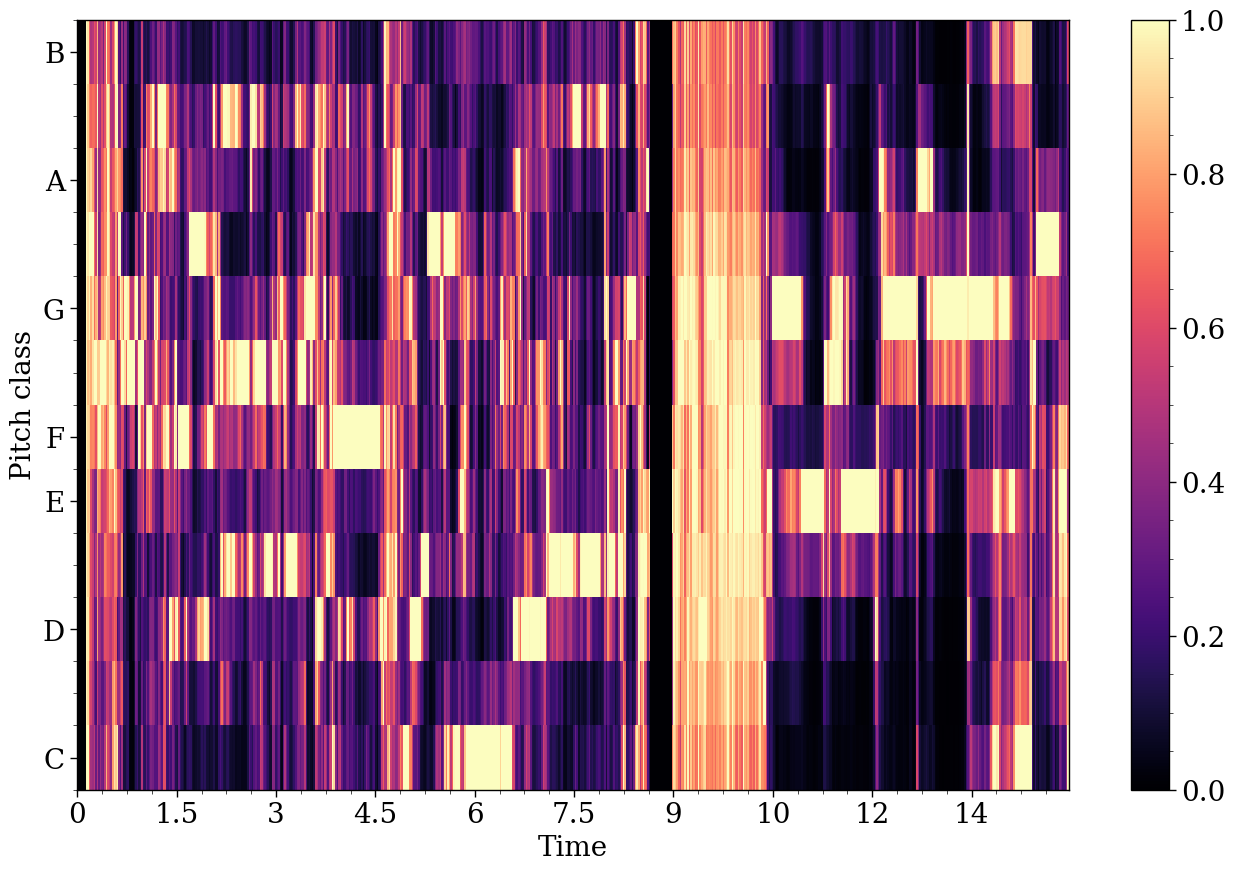

In [ ]:
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

*Agora uma versão mais nova de Tony Bennett e Amy Winehouse*

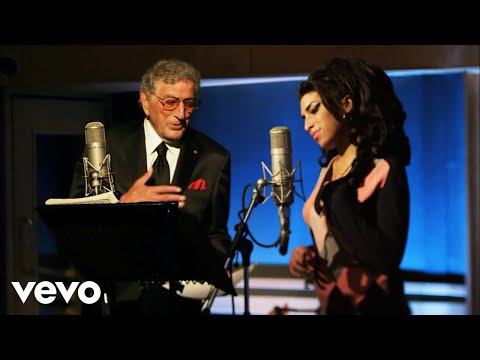

In [ ]:
ipd.YouTubeVideo('_OFMkCeP6ok')

Tanto em áudio quanto em cromagrama, as duas versões são bem diferentes.

In [ ]:
wave_amy, sr = librosa.load('mp3s/Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3',
                        duration=15)

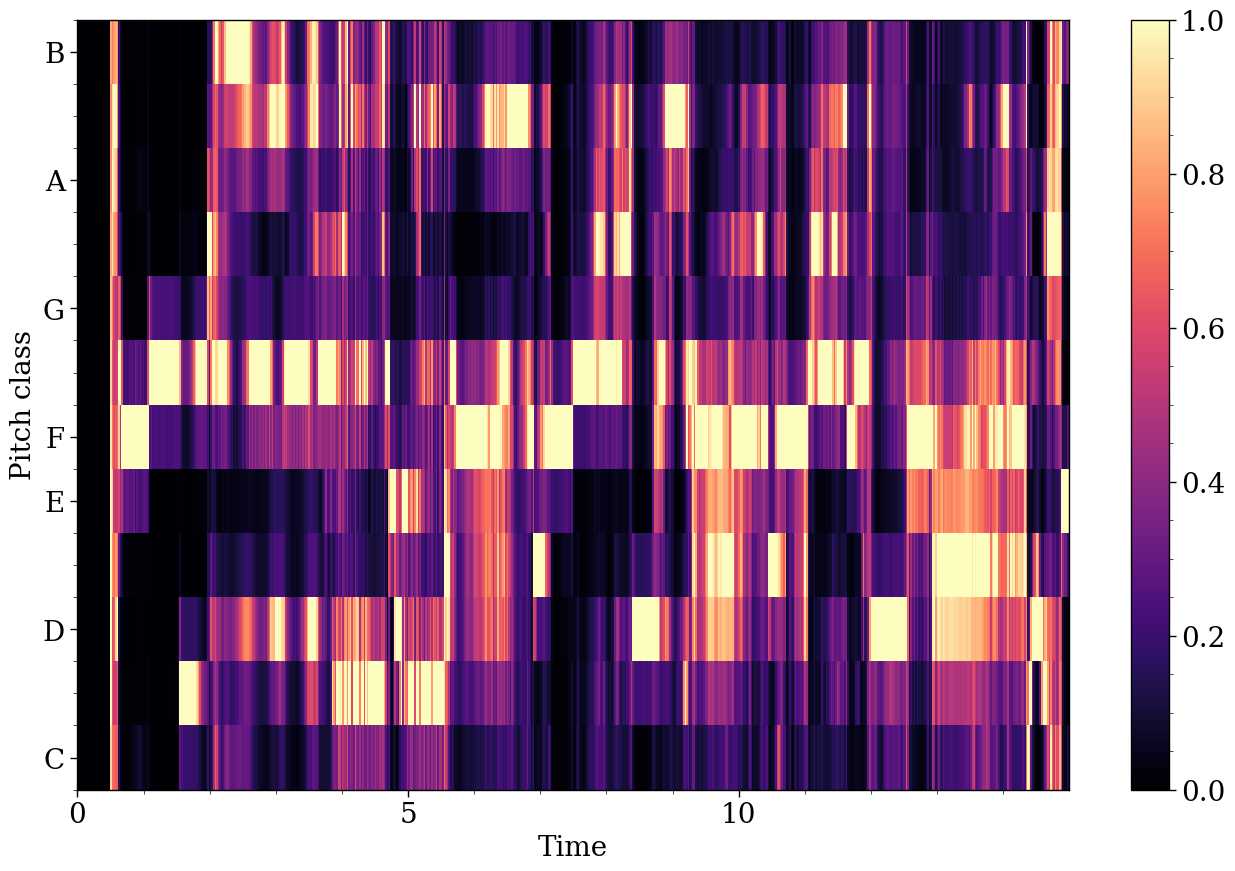

In [ ]:
chroma_amy = librosa.feature.chroma_stft(y = wave_amy, sr=sr)
chroma_amy.shape
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

Para comparar as duas com DTW, temos que computar a distância coseno entre as colunas.

In [ ]:
print(chroma_classic[:, 0].shape)
print(chroma_amy[:, 0].shape)

(12,)
(12,)


Aqui observamos nosso primeiro problema, a presença de zeros leva a disância para `nan`. Portanto, é mais comum usar versões suavizadas do cromagrama.

In [ ]:
sp.distance.cosine(chroma_classic[:, 100], chroma_amy[:, 60])

0.37100783686002337

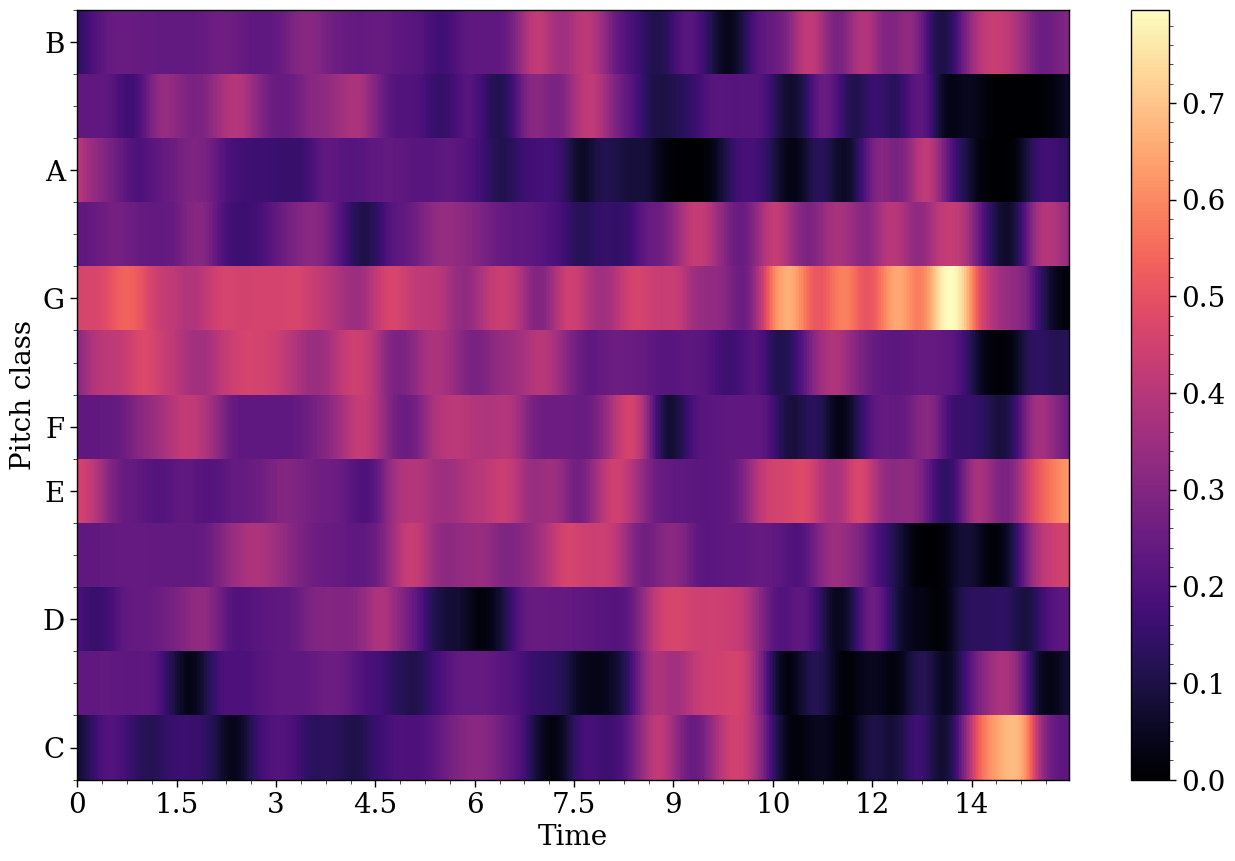

In [ ]:
chroma_classic = librosa.feature.chroma_cens(y = wave_classic, sr=sr)
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_classic,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

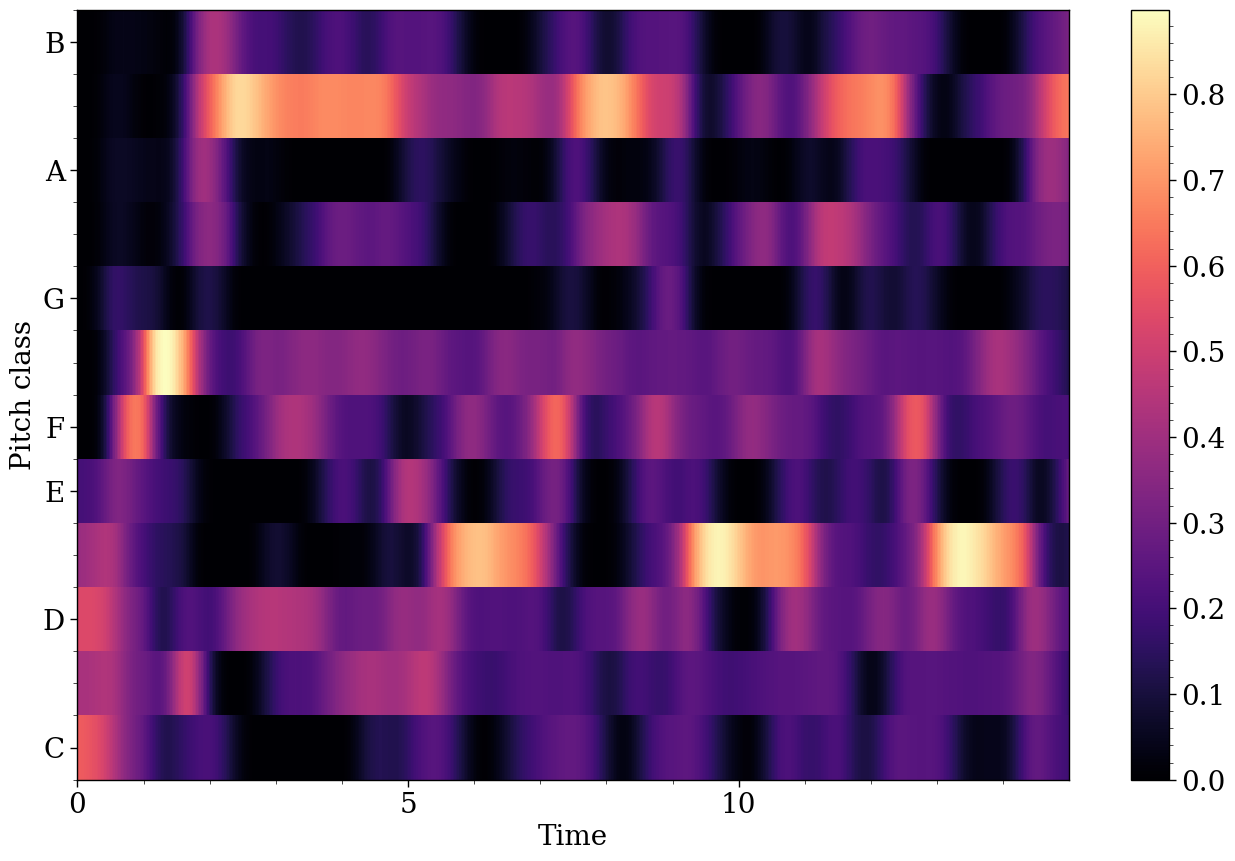

In [ ]:
chroma_amy = librosa.feature.chroma_cens(y = wave_amy, sr=sr)
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(chroma_amy,
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

Qual foi a ideia? Veja os slides das aula.

1. Tirar o log para ficar em uma *escala mais musical*
1. Somar uma pequena constante
1. Normalizar as colunas
1. Dentre outros

In [ ]:
sp.distance.cosine(chroma_classic[:, 0], chroma_amy[:, 0])

0.584327220916748

## Tarefa 1

Agora vamos programar. Sua primeira tarefa é implementar o Dynamic Time Warping. Seu código deve fazer uso de duas funções, uma para computar a matriz de custo. Esta se chama `dtw_table` abaixo. Pode usar a distância euclideana por simplicidade.

![](https://dcc.ufmg.br/~flaviovdf/mir/lab05/imgs/saida1.png)

**Questão 1**

Seu código deve gerar uma saída como a acima. Caso fique igual, 100%. Observe que a mesma não corresponde as saída do livros, Python indexa de cima para baixo. O livro de baixo para cima. De qualquer forma, isto é apenas um pequeno detalhe que não muda o algoritmo. Caso queira, mude o código para receber uma função de distância.

Seu código abaixo já vai receber matrizes onde as colunas são tempo e as linhas são observações.

In [ ]:
def dtw_table(X, Y):

    n_x = X.shape[1]
    n_y = Y.shape[1]
    D = np.zeros((n_x, n_y))
    for i in range(n_x):
      for j in range(n_y):
        dist = np.linalg.norm(X[:, i] - Y[:, j])
        if i == 0 and j == 0:
          D[i, j] = dist
        elif i == 0:
          D[i, j] = D[i, j - 1] + dist
        elif j == 0:
          D[i, j] = D[i - 1, j] + dist
        else:
          D[i, j] = min(D[i - 1, j], D[i, j - 1], D[i - 1, j - 1]) + dist
    return D

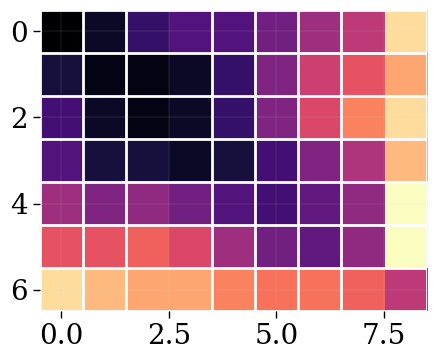

In [ ]:
def plot_dtw_table(D, path=None):
    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(D, cmap='magma')
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(D.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(D.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", bottom=False, left=False)

    if path:
        x = []
        y = []
        for n, m in path:
            y.append(n)
            x.append(m)
        ax.plot(x, y, color='r')

D = dtw_table(x[None], y[None]) # Não apagar isto é o teste!!!
plot_dtw_table(D)

**Questão 2**

Agora, crie uma função que retorna uma lista de tuplas. Esta lista contém o caminho ótimo do DTW. Para o exemplo acima com distância euclidiana, o caminho é:

```
[(6, 8),
 (5, 7),
 (5, 6),
 (4, 5),
 (3, 4),
 (3, 3),
 (2, 2),
 (1, 2),
 (1, 1),
 (0, 0)]
 ```

O plot agora deve ficar estilo a figura abaixo.

![](https://dcc.ufmg.br/~flaviovdf/mir/lab05/imgs/saida2.png)

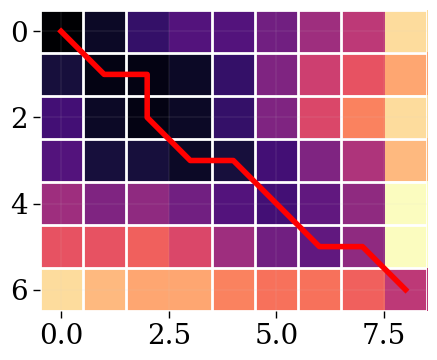

In [ ]:
def dtw(X, Y):
    if X.ndim == 1:
        X = X[None]
        Y = Y[None]

    D = dtw_table(X, Y)

    n_x = X.shape[1]
    n_y = Y.shape[1]

    n = n_x - 1
    m = n_y - 1
    path = [(n, m)]

    while n > 0 or m > 0:
        if n == 0:
            while m > 0:
                m = m - 1
                path += [(n, m)]

        if m == 0:
            while n > 0:
                n = m - 1
                path += [(n, m)]

        if D[n - 1, m - 1] < D[n - 1, m] and D[n - 1, m - 1] < D[n, m - 1]:
            n = n - 1
            m = m - 1
        elif D[n - 1, m] < D[n, m - 1]:
            n = n - 1
        else:
            m = m - 1
        path += [(n, m)]
    return D, path

D, path = dtw(x, y)
plot_dtw_table(D, path)

**Resposta para a questão 2:**

In [ ]:
def dtw_path(X, Y):
    D, path = dtw(X, Y)
    return path

In [ ]:
dtw_path(x, y)

[(6, 8),
 (5, 7),
 (5, 6),
 (4, 5),
 (3, 4),
 (3, 3),
 (2, 2),
 (1, 2),
 (1, 1),
 (0, 0)]

## Tarefa 2

Usando a biblioteca [FastDTW](https://github.com/slaypni/fastdtw) ordena as versões das músicas que são mais e menos similares com a versão de Tony Bennet e Amy Winehouse

```bash
$ pip install fastdtw
```

A biblioteca FastDTW é interessante pois é toda linear em tempo e memória. Assim, podemos computar a distância entre versões inteiras de músicas. Faça isso. Caso não execute, trunque em 2mins. Caso não execute, trunque em 1 min.

Abaixo executo a FastDTW com os 15 segundos que carregamos antes. Observe como passo a transposta, pois a biblioteca funciona em linhas, não em colunas, como o livro.

In [ ]:
! pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512545 sha256=62fb817d018017daac4bf5eee15daa99f9e6d560cd41d542e7f65c3086f5dff1
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
from fastdtw import fastdtw
import scipy.spatial as ss
x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(chroma_amy.T, chroma_classic.T, dist=ss.distance.cosine)

In [ ]:
#distance

In [ ]:
#path

**Questão 1**

Ordene as músicas por similaridade com a versão mais recent (Bennet e Winehouse). Indique sua resposta abaixo.

> Sua respota. Ou seja, os ids do YouTube aqui do mais até o menos similar. Escute as músicas, você percebe a similaridade? Em quais aspectos?

In [ ]:
#Carregar os Dados das músicas
import os
pasta_mp3s = "mp3s"
arquivos_mp3 = [os.path.join(pasta_mp3s, f) for f in os.listdir(pasta_mp3s) if f.endswith('.mp3')]

In [ ]:
#Obter Cromagramas
all_chromagrams = []
all_waves = []
for arquivo in arquivos_mp3:
    wave, sr = librosa.load(arquivo, duration=60)
    chroma = librosa.feature.chroma_cens(y = wave, sr=sr)
    all_chromagrams.append(chroma)
    all_waves.append(wave)
epsilon = 1e-8
adjusted_chromagrams = [chroma + epsilon for chroma in all_chromagrams]

In [ ]:
#Vamos calcular a similaridade de todas com a versão mais recente
similaridade = []
paths = []
reference_chroma = all_chromagrams[3]
for n in range(len(arquivos_mp3)):
    distance, path = fastdtw(adjusted_chromagrams[n].T, reference_chroma.T, dist=ss.distance.cosine)
    similaridade.append((distance, n))
    paths.append(path)
    print(f"Música {arquivos_mp3[n]}: Distance = {distance}")

Música mp3s/Stan Getz - Body and Soul-qPJpP2mxbsg.mp3: Distance = 789.790587581846
Música mp3s/Stan Getz Quintet - Body And Soul (Norgran Records 1952)-C2QwjXQMIZE.mp3: Distance = 778.5253337266631
Música mp3s/Chuck Berry _ Roy Eldridge- Body and Soul-0i5jQAAL60Y.mp3: Distance = 814.9795963351329
Música mp3s/Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3: Distance = 1.2035927809961322e-12
Música mp3s/Stan Getz Quintet - Body and Soul-3dgwQSrIWKs.mp3: Distance = 770.80527649567
Música mp3s/Sonny Stitt _ Body and Soul (1948)-H_IZdoQaoj0.mp3: Distance = 747.1803857289675
Música mp3s/Body and soul Don Byas-402zBdIdmNU.mp3: Distance = 782.6582440745714
Música mp3s/John Coltrane _Body And Soul_-8z-dDWrIKDQ.mp3: Distance = 697.940470176171
Música mp3s/Coleman Hawkins-Body and Soul 1939.wmv-Sul_9BcgOOI.mp3: Distance = 795.1075215617768
Música mp3s/David Murray Quartet - Body And Soul (Duet)-p0tEqbNHi64.mp3: Distance = 909.4867425100869
Músi

In [ ]:
#Vamos ordenar
similaridade.sort(key=lambda x: x[0])
print(similaridade)
print("\nMúsicas Ordenadas pela Similaridade (ordem crescente):")
for distance, index in similaridade:
    print(f"Música {arquivos_mp3[index]}: Distance = {distance}")

[(1.2035927809961322e-12, 3), (673.7986265793965, 11), (697.940470176171, 7), (710.7599956397878, 12), (747.1803857289675, 5), (751.5267609355594, 10), (770.80527649567, 4), (778.5253337266631, 1), (782.6582440745714, 6), (787.3487723803272, 14), (789.790587581846, 0), (795.1075215617768, 8), (814.9795963351329, 2), (824.8569949397706, 13), (909.4867425100869, 9)]

Músicas Ordenadas pela Similaridade (ordem crescente):
Música mp3s/Tony Bennett, Amy Winehouse - Body and Soul (from Duets II - The Great Performances)-_OFMkCeP6ok.mp3: Distance = 1.2035927809961322e-12
Música mp3s/JOHN COLTRANE - BODY AND SOUL-jUUNYtSkseI.mp3: Distance = 673.7986265793965
Música mp3s/John Coltrane _Body And Soul_-8z-dDWrIKDQ.mp3: Distance = 697.940470176171
Música mp3s/John Coltrane Quartet - Body And Soul-62FQT9PXWM4.mp3: Distance = 710.7599956397878
Música mp3s/Sonny Stitt _ Body and Soul (1948)-H_IZdoQaoj0.mp3: Distance = 747.1803857289675
Música mp3s/Chu Berry , Roy Eldridge - BODY AND SOUL-Lor80WUVbtw.

R: A música mais semelhante "JOHN COLTRANE - BODY AND SOUL", de fato, apresenta muita semelhança com a música de Bennett e Winehouse utilizada como referência. O que, para mim, foi surpreendente, já que, a música de referência é um dueto e a música de John Coltrane é instrumental. Além disso, a versão de John também é mais acelerada.
Olhando agora para a música menos semelhante, "David Murray Quartet - Body And Soul (Duet)", ela segue um rítmo mais lento, um tom mais grave e firme.

**Questão 2**

Plote o caminho de sincronização da música mais e menos similar. Isto é, no eixo-x você pode usar o tempo da música referência (Bennet e Winehouse). No eixo-y, o tempo das outras músicas.

> Qual interpretação você tira do plot?

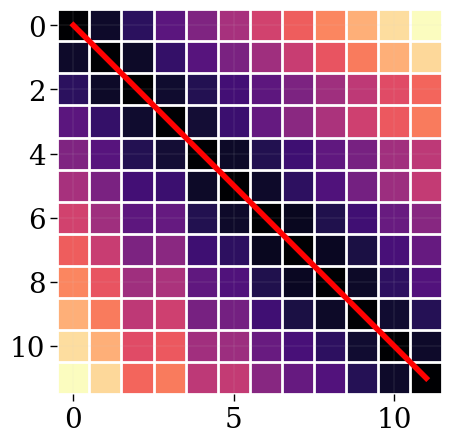

In [ ]:
#Para isso vamos reutilizar a função acima 'plot_dtw_table'
# Dela com ela mesma
D, path = dtw(reference_chroma.T, adjusted_chromagrams[3].T)
plot_dtw_table(D, path)

In [ ]:
! pip install dtw

  Preparing metadata (setup.py) ... done
  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5300 sha256=9ce375bb70e715b3e8867ba654d0896b679603e15b65c4e1e9d6dc0f5b652229
  Stored in directory: /root/.cache/pip/wheels/71/31/62/5e67f6e31521b8cc1652aa58b1ed0c892514d01eeee85fd49c
Successfully built dtw


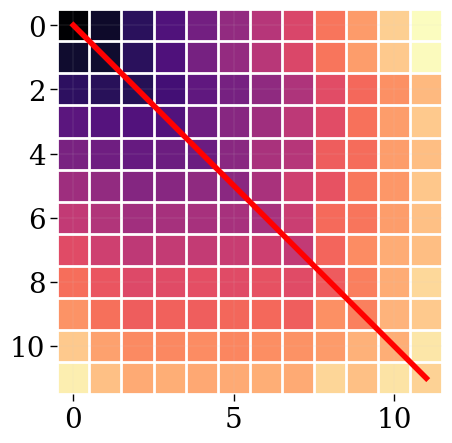

In [ ]:
#Dela com a mais similar
D, path = dtw(reference_chroma.T, adjusted_chromagrams[11].T)
plot_dtw_table(D, path)

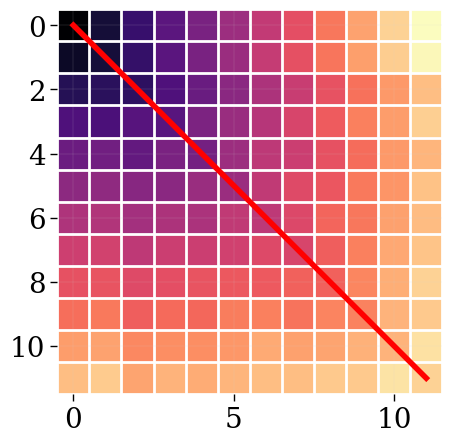

In [ ]:
#Dela com a menos similar
D, path = dtw(reference_chroma.T, adjusted_chromagrams[9].T)
plot_dtw_table(D, path)

R: O cromagrama da música de referência é completamente simétrico em relação a diagonal, o que mostra que eles são 100% similares, como era de se esperar. Agora os outros dois não são simétricos, o primeiro, um pouco menos, pelo fato de ser mais semelhante.

**Questão 3**

Plote os cromagramas da músicas mais e menos similar. Compare com a versão base.

> Qual interpretação você tira do plot?

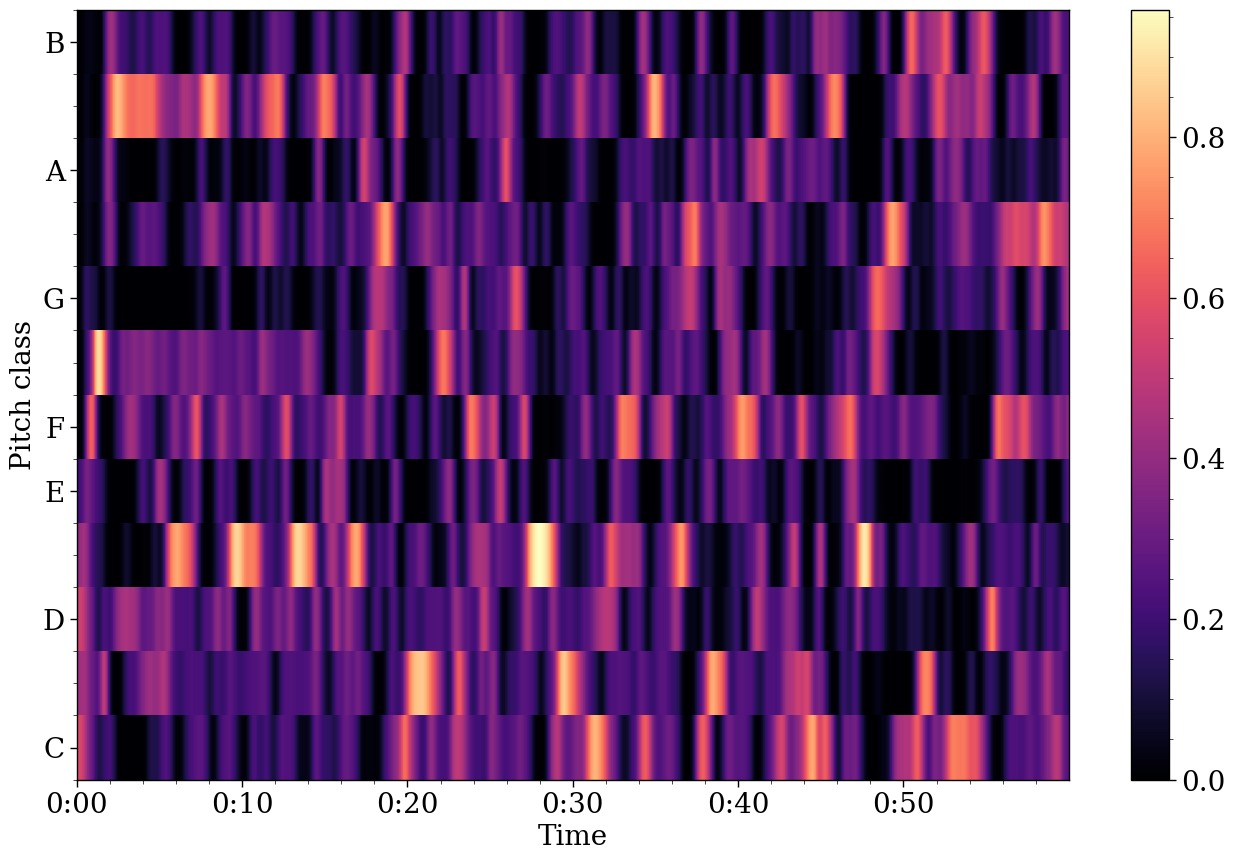

In [ ]:
#Cromagrama da interpretação da Amy Winehouse e do Bennet
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(all_chromagrams[12],
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

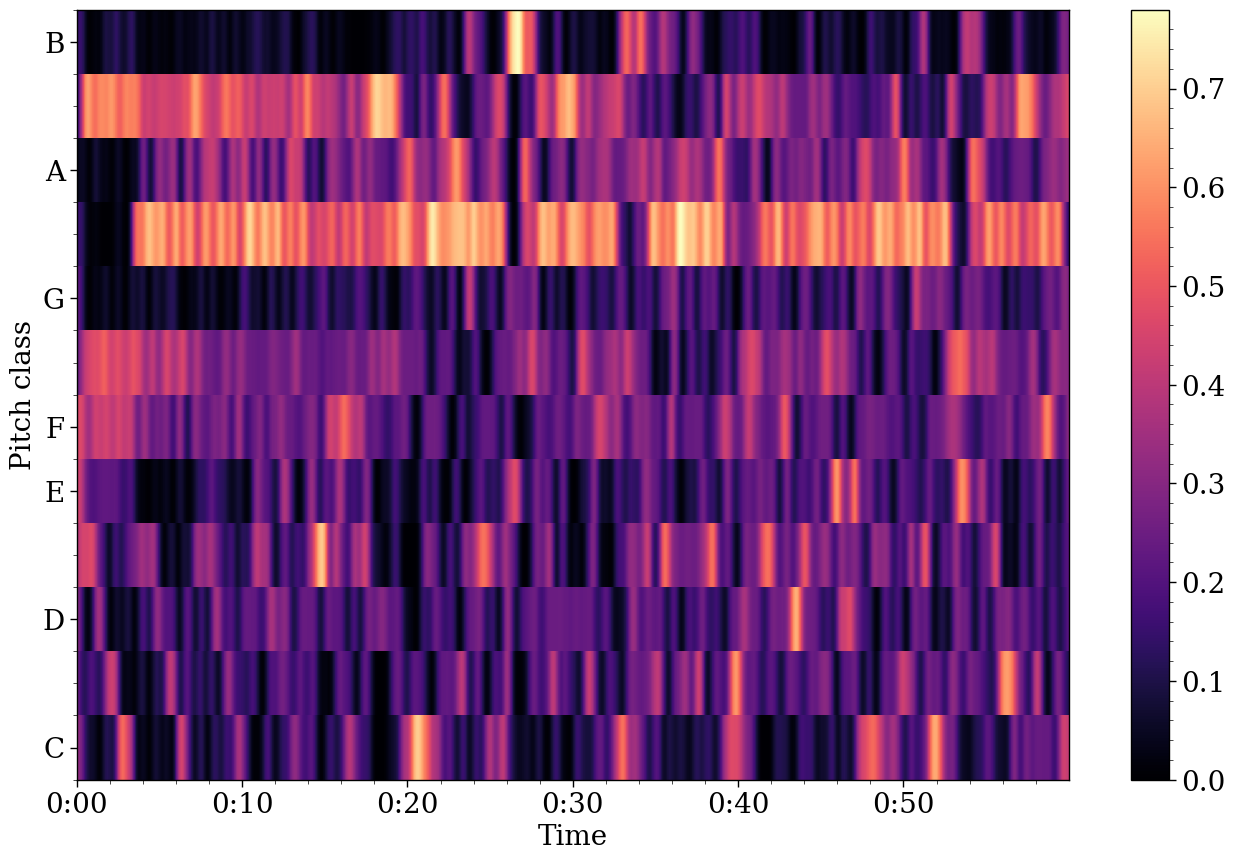

In [ ]:
#Cromograma da interpretação mais similar
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(all_chromagrams[13],
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

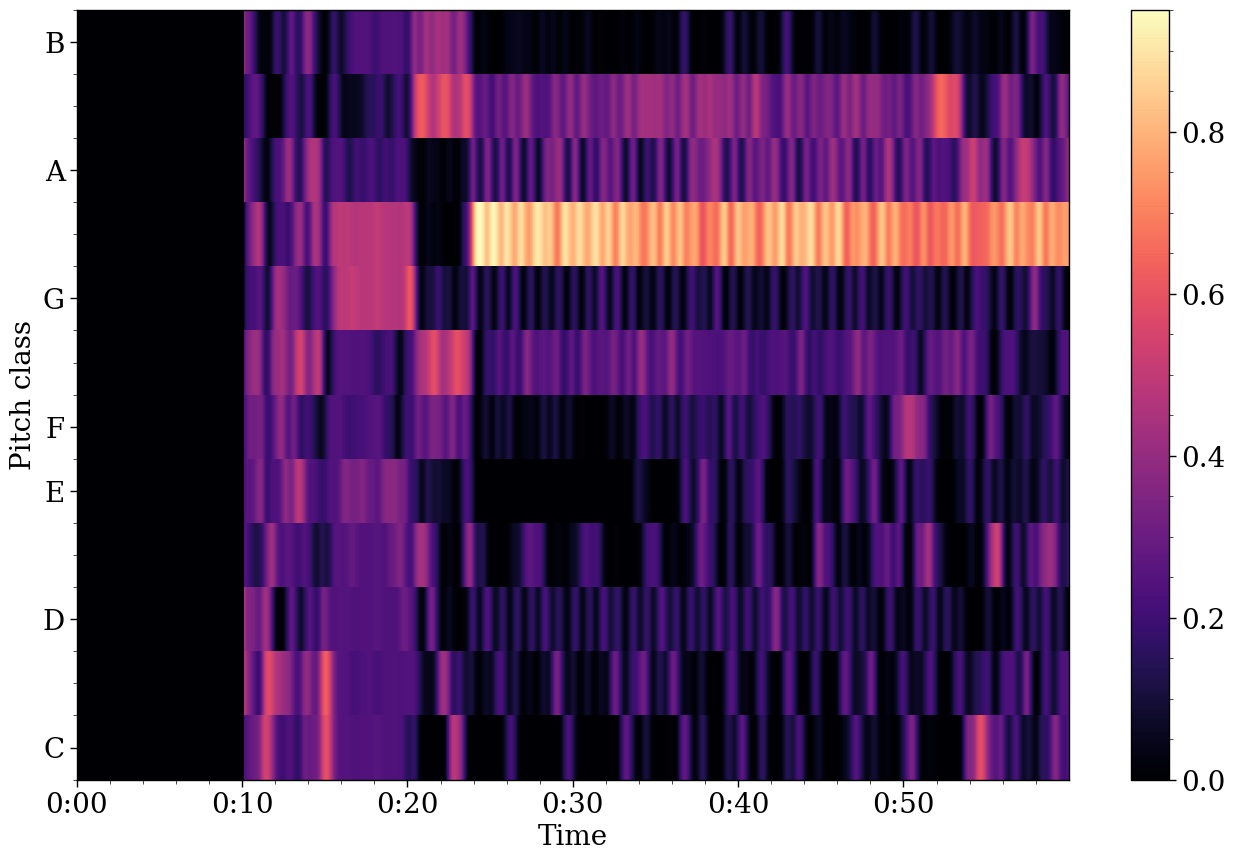

In [ ]:
#Cromograma da interpretação menos similar
fig, ax = plt.subplots(1, 1)
img = librosa.display.specshow(all_chromagrams[4],
                               y_axis='chroma',
                               x_axis='time',
                               ax=ax)
fig.colorbar(img, ax=ax)

O cromagrama do áudio menos semelhante apresenta, nos primeiros segundos, uma região completamente preta. Isso ocorre devido à presença de alguns segundos de silêncio no início da música, o que resulta na ausência de energia em todas as frequências nesse intervalo.

Por outro lado, o cromagrama do áudio mais semelhante é completamente preenchido e, como esperado, se assemelha bastante ao cromagrama da música de referência. Embora existam algumas diferenças perceptíveis, como a presença de uma faixa laranja, isso indica que determinado semitom está mais acentuado em boa parte da música, mesmo que essa característica não esteja presente no cromagrama original.